# Kickstarter: What Makes Projects Succeed/Fail?
#### IntroCM Spring 2016, Cornell Tech
Inna Shteinbuk (ibs26) & Huai-Che Lu (hl938)

## Introduction
Crowdfunding is the practice of raising venture from the general public. Sites like [Kickstarter](https://www.kickstarter.com/) and [Indiegogo](https://www.indiegogo.com/) provide internet-mediated services to support the process of requesting and offering monetary help. In this project, we looked into different textual and social factors to see how they relate to the success or failure of projects.
​
On Kickstarter, creators launch projects where they can talk about the products and demonstrate the progress to attract backers' willingess to fund the projects. In return, creators give backers different rewards based on the sponsored amount. It's notable that the pledge rewards come with a delay after the backers provide the money, which is largest difference between crowdfunding sites and other e-commerce services: the risks for backers are a lot more higher than the risks for buyers.
​
## Related Work
Althoff et al. looked at the textual and social factors in [Random Acts of Pizza (RAOP)](http://randomactsofpizza.com/) that influence the success of altruistic requests[1]. In RAOP, requesters ask for free pizzas with texts and/or photos. In return, they are required to express gratitude (in a post) after receivng help from others. The authors summarized that gratitude, reciprocity, urgency, and social status are the main factors that distinguish successful requests from the failed ones.
​
Mitra et al. analyzed the language usded in Kickstarter projects to persuade backers, and used the corpus to develop a predictive model using LIWC and other natural language processing techniques[2]. They identified factors including reciprocity, scarcity, social proofs, social identities, liking, and authority are the key drivers for a project to be funded.
​
## Research Question
In this project, we looked at both textual and social factors on Kickstarter to see how the information presented on Kickstarter affect the creator-backer dynamic and the success/failure of projects.
​
## Hypotheses
​
Based on our research question, we developed the following hypotheses and checked whether the data at our disposal approve or disapprove them.
​
- The whole dataset
    - **H1 [Trust]: ** Project creators are asking more money overtime.
    - **H2 [Reputation]: ** Project creators with good records are more likely to get help.
- Tech dataset 
    - **H3 [Reciprocity]: ** People who have already been backed, are more likely to back other projects.
    - **H4 [Similarity]:**
        - ** H4.1 (Interest-based): ** People are more likely to back projects in the same category as the projects they’ve created.
        - ** H4.2 (Location-based): ** People are more willing to back creators from the same country.
    - **H6 [Effort]:**
    - **H7 [Language]:**
    
## CM Theories
- Signaling Theory
    - There are several signals backers might take advatage of to help them decide whether to back a project or not. For example, past records of a project creator (reputaion), the length of the project description (effort), and whether there's a video (effort) could all be factors in the decision making process.
- Reciprocity
    - People are more willing to offer help after recieving one.
- Similarity
    - People are more willing to offer help to those who resemble themselves.

## Dataset Overview
### Original Data
The dataset contains information of 154,504 Kickstarter projects from 04/2009 - 04/2016. For each project, the following columns are provided:
- Numerical
    1. Timestamps: Created At, Deadline
    2. Monetary: Goal, Pledged
- Categorical
    1. Category: Super-category, Sub-category
    2. State (Successful, Failes, Live, Canceled, Suspended)
    3. Location: Country, State
- Textual
    1. Name
    2. Blurb
    3. URL
    4. Creator ID

### Scraped Data
In additional to the original data, we wrote our own scrapers to get more information on a subset of the original dataset (successful or failed projects in Technology category from 01/2014 - 04/2016). The following information was collected for each project:
- Numerical
    1. Projects creators backed: Category, Timestamps
    2. Backer Community: Top countries, Top cities
- Cetegorical
    1. Does The Project Has Video
- Textual
    1. Full project description
    2. Risks and challenges

** Import Packages **

In [1]:
import time
import json
from collections import Counter
from datetime import datetime
import glob
import os

%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
plt.style.use('ggplot')

import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import *
from nltk.stem import SnowballStemmer
import nltk.data
from nltk.corpus import stopwords
import string

## Dataset Introduction
** Exploration of full dataset **

In [2]:
path ='../Untitled Folder/downloaded_kickstarter_data'
all_files = glob.glob(os.path.join(path, "*.csv"))
df = pd.concat((pd.read_csv(f) for f in all_files)) 


### Understand how each category does on Kickstarter. 
The circles are how popular the project is, and the shade of green represents the ratio of success/failed projects in each category. We can see that design is the most successful, and music seems to be the most popular. But we chose to explore technology.

In [7]:
df['specific_category'] = df['category'].apply(lambda x: json.loads(x)['slug']) 
df['super_category'] = df['specific_category'].apply(lambda x: x.split('/')[0])    

In [8]:
super_cat_dict = {}
for cat in df['super_category'].unique():
    success = sum(df[df['super_category'] == cat]['state'] == 'successful')
    failed = sum(df[df['super_category'] == cat]['state'] == 'failed')
    total = df[df['super_category'] == cat].shape[0]
    super_cat_dict[cat] = [total, success, failed]

In [10]:
#{category: [total,success, failed], ...}
super_cat_dict

{u'art': [15568, 6291, 7843],
 u'comics': [3108, 1599, 1098],
 u'crafts': [2741, 596, 1778],
 u'dance': [953, 481, 385],
 u'design': [6576, 4398, 1433],
 u'fashion': [7933, 1712, 5158],
 u'film & video': [25741, 13855, 10136],
 u'food': [9051, 1787, 6045],
 u'games': [11587, 6271, 4084],
 u'journalism': [2053, 357, 1379],
 u'music': [27378, 15153, 10270],
 u'photography': [3489, 834, 2178],
 u'publishing': [18886, 7902, 9976],
 u'technology': [16863, 3304, 10429],
 u'theater': [2578, 1351, 939]}

In [11]:
#export this csv to tableau
super_cat_csv = pd.DataFrame(super_cat_dict).T
super_cat_csv.to_csv("super_cat_csv.csv", header=['total', 'successful', 'failed'])

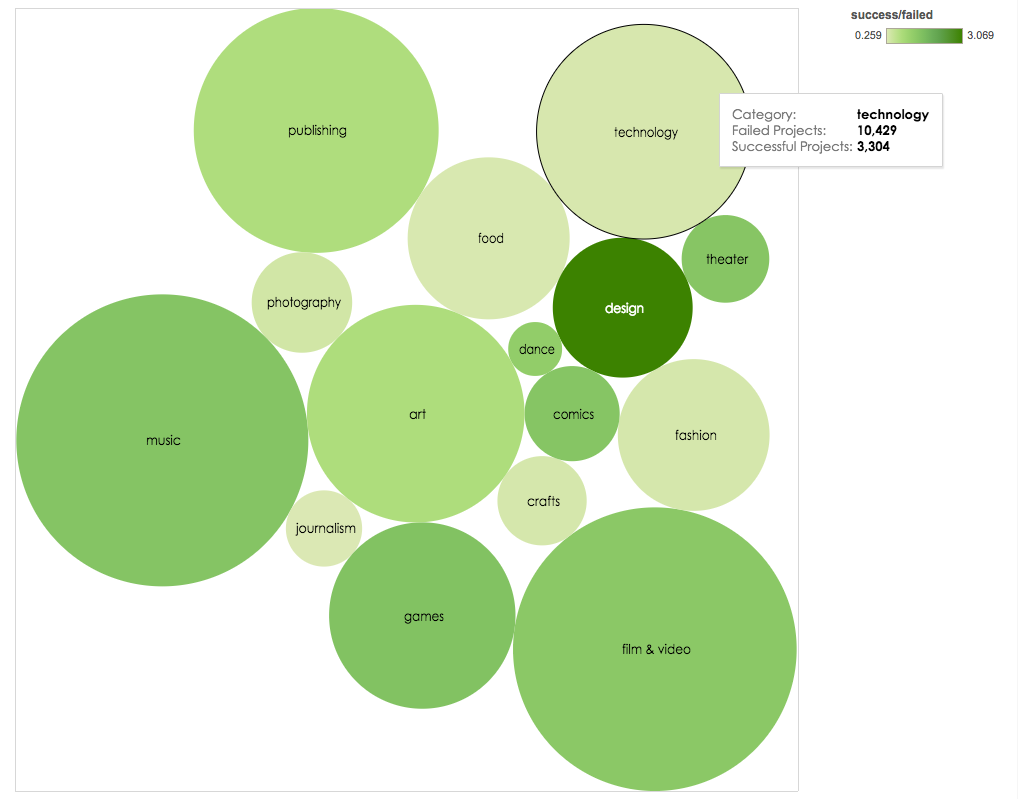

In [12]:
#screenshot (used this for presentation)
from IPython.display import Image
Image(filename='../Untitled Folder/tableau_graph.png') 

## Community critical mass
We plotted Failed and Successful projects from Kickstarter over the course of the dataset. 
The earliest date was and the scrapign went until
We found that the data looks kind of exponential, and we attribute this to the critical mass theory.
As more people joined, critical mass was reached so that even more people joined, and this in turn
helped the Kickstarter community grow. Due to critical mass and the expanding number of users
on Kickstarter, new users are more willing to join the community, start their own projects, and back
projects.
We were also surprised to see that there are actually more successful projects than failed projects.
This was until May 2015, but we are not quite sure why now failed projects are exceeding successful one
'''1

In [3]:
#start and end dates of dataset
max_time = max(df['created_at'])
min_time = min(df['created_at'])
print time.ctime(min_time)
print time.ctime(max_time)
print time.strftime("%D %H:%M", time.localtime(max_time))
print time.strftime("%D ", time.localtime(max_time))

kstr_sorted = df.sort_values(['created_at'])
kstr_sorted['successful_count'] = kstr_sorted['state'].apply(lambda x: 1 if x =='successful' else 0) 
kstr_sorted['failed_count'] = kstr_sorted['state'].apply(lambda x: 1 if x =='failed' else 0) 

kstr_sorted['running_count_successful'] = kstr_sorted['successful_count'].cumsum()
kstr_sorted['running_count_failed'] = kstr_sorted['failed_count'].cumsum()

new_df = pd.concat([kstr_sorted['created_at'], kstr_sorted['running_count_successful'], kstr_sorted['running_count_failed']], axis=1, keys=['date', 'number_successful', 'number_failed'])
new_df['read_date'] = new_df['date'].apply(lambda x: time.strftime("%D ", time.localtime(x)))


Tue Apr 21 13:35:35 2009
Thu Apr 14 20:14:17 2016
04/14/16 20:14
04/14/16 


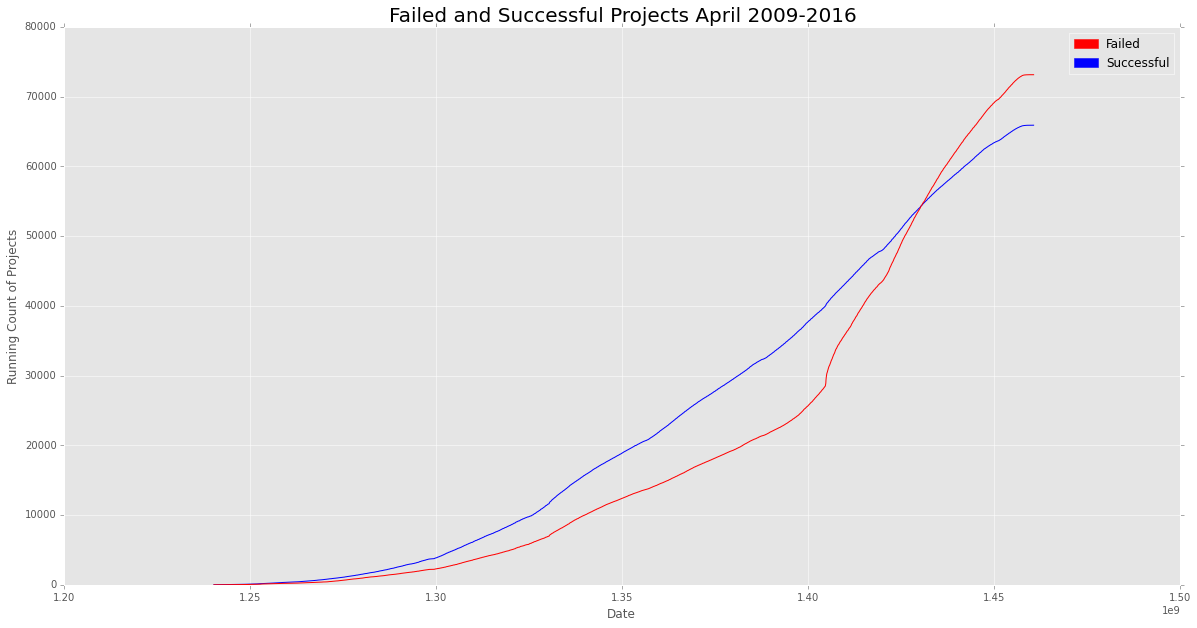

In [4]:
plt.figure(figsize=(20,10)) 
plt.style.use('ggplot')
plt.plot(new_df['date'], new_df['number_successful'], label = 'number successful', color = 'b')
plt.plot(new_df['date'], new_df['number_failed'], label = 'number failed', color = 'r')

red_patch = mpatches.Patch(color='red', label='Failed')
blue_patch = mpatches.Patch(color='b', label='Successful')
plt.legend(handles=[red_patch, blue_patch])

plt.ylabel('Running Count of Projects')
plt.xlabel('Date')

plt.title("Failed and Successful Projects April 2009-2016", fontsize=20 )


## H1: Trust
** Project creators are willing to ask for more money overtime. **

We're interested in users' overall trust in the crowdfunding platform and the ecosystem. To measure this construct, we looked at the money people are asking for. The idea was that the more people are asking for, the more trust they have.

We aggregated the median of project goals (the variation is pretty large, so we use median instead of mean to minimize the effect of outliers) for each month, and ploted bar charts for all projects as well as the successful and failed ones. The result showed an increasing trend of the money people are asking for on Kickstarter. For all projects, the number has increased from 3K USD to 5K USD in the past 7 years. This supported our hypothesis that people's trust increases overtime.

In [465]:
df = pd.read_csv('data/Kickstarter_all.csv', encoding='utf-8', index_col=0)
df.drop_duplicates(inplace=True)
df = df[(df.state == 'successful') | (df.state == 'failed')]
df.sort_values(by='created_at', inplace=True)

In [466]:
# convert Unix time to month string
def timestamp2monthstr(t):
    d = datetime.fromtimestamp(t)
    return "%d/%d" % (d.month, d.year)

# convert month string to the Unix time of the first day of that month
def monthstr2timestamp(s):
    first_day = '1/' + s
    return time.mktime(datetime.strptime(first_day, '%d/%m/%Y').timetuple())

df['created_month'] = df.created_at.apply(timestamp2monthstr)

In [467]:
def plot_trust(df, key):
    gb = df.groupby(key)
    median_goals = gb.apply(lambda g: np.median(g.goal))
    
    timestamps = [monthstr2timestamp(key) for key, g in gb]
    median_goals = [mg for mg in median_goals]
    
    df_plot = pd.DataFrame()
    df_plot['median_goal'] = pd.Series(median_goals)
    df_plot['timestamp'] = pd.Series(timestamps)
    df_plot.sort_values(by='timestamp', inplace=True)
    
    def millions(y, pos):
        'The two args are the value and tick position'
        return '$%dK' % (y * 1e-3)

    def timestamp_formatter(t, pos):
        return timestamp2monthstr(timestamps[pos]) if pos % 3 == 0 else ""

    plt.figure()
    ax = df_plot.plot.bar(x='timestamp', y='median_goal', figsize=(10, 5))
    ax.set_ylabel('Median Goal (USD)')
    ax.set_xlabel('Time')
    ax.yaxis.set_major_formatter(FuncFormatter(millions))
    ax.xaxis.set_major_formatter(FuncFormatter(timestamp_formatter))
    plt.show()

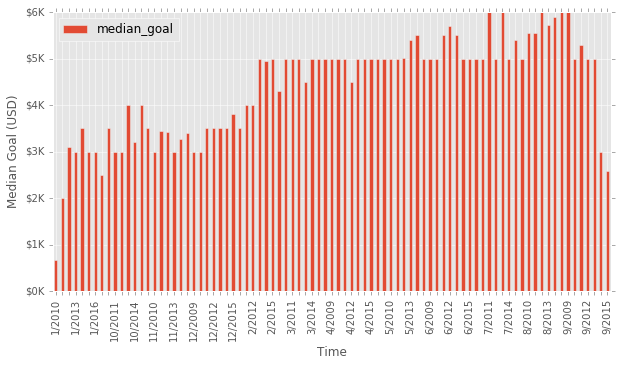

In [468]:
plot_trust(df, 'created_month')

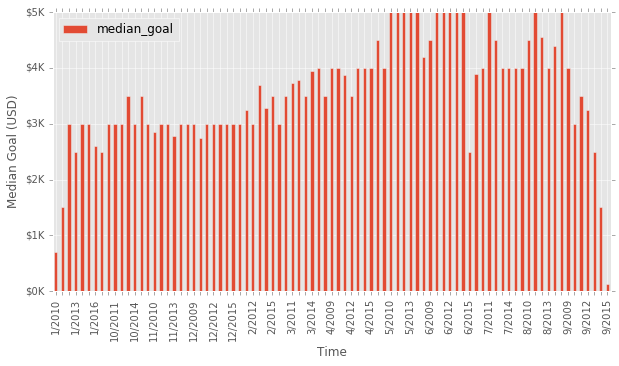

In [469]:
plot_trust(df[df.state == 'successful'], 'created_month')

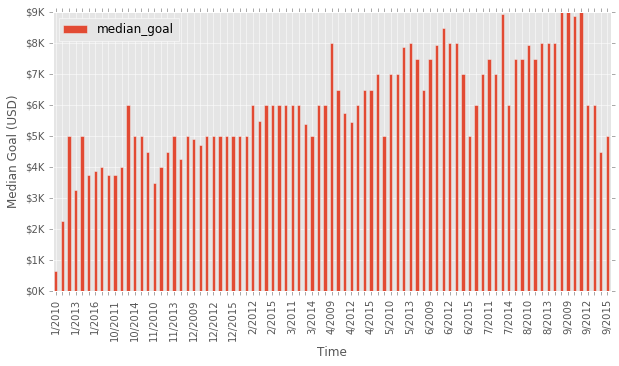

In [470]:
plot_trust(df[df.state == 'failed'], 'created_month')

## H2: Reputation
** Project creators with good records are more likely to get help. **

Due to the nature of crowdfunding, there are risks that the project won't be carried out. Therefore, we thought that people would use reputation of a creator, the past records of his/her projects, as an assessment signal to help them determine whether to sponsor the project or not.

We looked at people who have created more than 3 projects to see whether the success rate of their first 3 projects (priors) correlates to that of the rest of the projects (subsequents). The data showed that the correlation coefficient between the prior and subsequent succcess rate was 0.652, which could be interpreted as highly correlated. Also, the average subsequent success rate for people with high prior success rates (> 60%) was over 80%, while that for those with low prior success rate (< 30%) was less than 20%, which again proved the importance of reputation on Kickstarter. Therefore, the data we collected also supported the hypothesis of reputation.

In [639]:
df = pd.read_csv('data/Kickstarter_all.csv', encoding='utf-8', index_col=0)
df.drop_duplicates(subset=['project_url'], inplace=True)
df.sort_values(by='created_at', inplace=True)

In [640]:
df.get(['created_at', 'creator_id']).head()

,created_at,creator_id
2021,1240335335,williambrittelle
276,1240366270,Samplefreq
3767,1240514851,1309681027
1426,1240600507,darkpony
1689,1240637870,dphiffer


Group the data by creator's id, and take those who have created more than 3 projects into consideration.

In [641]:
gb_id = df.groupby('creator_id') \
    .filter(lambda g: len(g) > 3) \
    .groupby('creator_id')

In [642]:
print(str(len(gb_id)) + " project creators.")

1033 project creators.


In [643]:
def success_rate(states):
    states = Counter(states)
    return float(states['successful']) / sum(states.values())

In [656]:
df_stats = pd.DataFrame()
df_stats['prior'] = gb_id.apply(lambda g: success_rate(g.state.values[:3]))
df_stats['subsequent'] = gb_id.apply(lambda g: success_rate(g.state.values[3:]))

df_stats['prior_level'] = df_stats.prior.apply(lambda p: 'Low' if p < 0.3 else 'Medium' if p < 0.6 else 'High')

In [657]:
corrcoef = np.corrcoef(df_stats.prior, df_stats.subsequent)[0, 1]
print("Correlation coefficient r = %.3f" % (corrcoef))

Correlation coefficient r = 0.652


In [658]:
gb_level = df_stats.groupby('prior_level')
print len(gb_level.get_group('High'))
print len(gb_level.get_group('Medium'))
print len(gb_level.get_group('Low'))

723
124
186


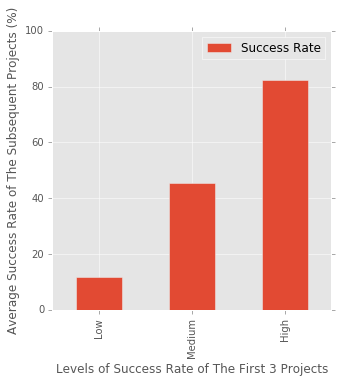

In [659]:
gb_level = df_stats.groupby('prior_level')
df_plot = gb_level.subsequent.mean().reset_index(name='Success Rate')

levels = ['Low', 'Medium', 'High']
mapping = {level: i for i, level in enumerate(levels)}
key = df_plot['prior_level'].map(mapping)    
df_plot = df_plot.iloc[key.argsort()]

def percentage(x, pos):
    return '%d' % (x * 100)

plt.figure()
ax = df_plot.plot.bar(x='prior_level', y='Success Rate', figsize=(5, 5))
ax.set_ylabel('Average Success Rate of The Subsequent Projects (%)')
ax.set_xlabel('Levels of Success Rate of The First 3 Projects')
ax.set_ylim(bottom=0.0, top=1.0)
ax.yaxis.set_major_formatter(FuncFormatter(percentage))
plt.show()

## H3: Reciprocity
** People who have already been backed are more likely to back other projects. ** 

Reciprocity refers to the social norm where after receiving a favor, people tend to pay it back in some way [4]. In the crowdfunding context, this could be interpreted as how creators' backing behavior changes in response to the help they received from other backers for their own projects.

We grouped project creators by the state of their first projects, which gave us 4 groups: (successful, failed, suspended, and canceled). Then, we compare the number of projects they backed after the first project was created **[*]**. On average, people in the successful group backed more than 2.5 projects while those in the failed group only backed less than 0.5 projects after the first project. The difference between the successful group and failed group was statistically significant (p < .01). The finding was consistent with the reciprocity theory, which supported the hypothesis.

**[*]** There might be some bias here since we didn't know when they backed the project exactly, but since projects are only live for a certain period of time, the data is still valid to some extent. 

In [475]:
df = pd.read_csv('data/Kickstarter_Tech.csv', encoding='utf-8', index_col=0)
tech_creators = df.creator_id.unique()

In [522]:
df_reciprocity = df.get(['creator_id', 'backed_timestamps']).drop_duplicates()
df_reciprocity.backed_timestamps = df_reciprocity.backed_timestamps.apply(json.loads)
df_reciprocity.sort_values(by='backed_timestamps', ascending=False).head() # For visualization

,creator_id,backed_timestamps
3696,1056965878,"[1462827709.0, 1461145023.0, 1452657882, 14509..."
11488,1984955468,"[1462814718.0, 1445888755.0, 1446334099.0, 144..."
9464,420233999,"[1462800001.0, 1461693164.0, 1460009406, 14573..."
10613,1759750922,"[1462768318.0, 1447318380]"
6297,2040856244,"[1462548024.0, 1331209343.0]"


In [480]:
df_all = pd.read_csv('data/Kickstarter_all.csv', encoding='utf-8', index_col=0)
df_all['creator_id'] = df_all.creator.apply(lambda x: json.loads(x)['id'])
df_all.sort_values(by='created_at', inplace=True)
all_gb_id = df_all.groupby('creator_id')

In [478]:
print("%d unique creators in Tech dataset." % (len(tech_creators)))

10846 unique creators in Tech dataset.


In [526]:
def get_first_state(row):
    cid = row.creator_id
    first_state = all_gb_id.get_group(cid).state.values[0]
    return first_state

def get_backed_count_after_first(row):
    cid = row.creator_id
    backed_timestamps = row.backed_timestamps
    first_created_at = all_gb_id.get_group(cid).created_at.values[0]
    return len(filter(lambda x: x > first_created_at, backed_timestamps))

In [527]:
df_reciprocity['backed_count_after_first'] = df_reciprocity.apply(get_backed_count_after_first, axis=1)
df_reciprocity['first_state'] = df_reciprocity.apply(get_first_state, axis=1)

In [529]:
df_reciprocity.sort_values(by='backed_timestamps', ascending=False).head()

,creator_id,backed_timestamps,backed_count_after_first,first_state
3696,1056965878,"[1462827709.0, 1461145023.0, 1452657882, 14509...",10,failed
11488,1984955468,"[1462814718.0, 1445888755.0, 1446334099.0, 144...",8,successful
9464,420233999,"[1462800001.0, 1461693164.0, 1460009406, 14573...",6,successful
10613,1759750922,"[1462768318.0, 1447318380]",2,successful
6297,2040856244,"[1462548024.0, 1331209343.0]",1,failed


In [584]:
reciprocity_gb_state = df_reciprocity.groupby('first_state')

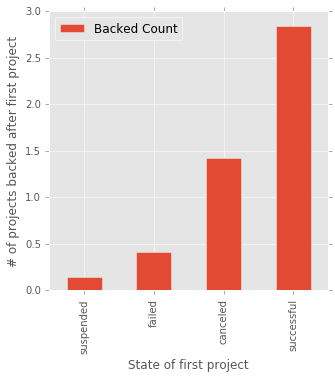

In [633]:
df_plot = reciprocity_gb_state.backed_count_after_first.mean().reset_index(name='Backed Count')

states = ['suspended', 'failed', 'canceled', 'successful']
mapping = {state: i for i, state in enumerate(states)}
key = df_plot['first_state'].map(mapping)    
df_plot = df_plot.iloc[key.argsort()]

plt.figure()
ax = df_plot.plot.bar(x='first_state', y='Backed Count', figsize=(5, 5))
ax.set_ylabel('# of projects backed after first project')
ax.set_xlabel('State of first project')
plt.show()

In [583]:
successful = reciprocity_gb_state.get_group('successful').backed_count_after_first.values
failed = reciprocity_gb_state.get_group('failed').backed_count_after_first.values

t, p = stats.ttest_ind(successful, failed, equal_var=False)
print 'p-value of T-test:', p, ' < .01'

p-value of T-test: 4.48374036884e-78  < .01


## H4: Similarity

Past research in social psychology has shown that people are more willing to help those who are similar to themselves [3]. Based on the similarity theory, we developed 2 related hypotheses (H4.1 and H4.2) to see if it could also be applied to the online crowdfunding context by measuring interest-based similarity ($S_I$) and location-based similarity ($S_L$), respectively.

## H4.1: Similarity (Interest-Based)
** Creators are more likely to back projects in the same category as the projects they’ve created. **

It's resonable to assume that people back projects based on their own interests. Another assumption we made was that a creator's interest could be represented by the projects he or she launched. For example, Tony has created 3 software projects and 2 boardgame projects, so we assume that he is interested in Technology and Game.

We define an interest-based similarity $S_I$ for each project creator, a measure with range [0, 1.0] that represents the fraction of projects a creator backed within the categories he/she has created among all the backed projects.

For each project creator in the Tech dataset, we computed $S_I$ for both super-categories (Art, Design, Technology, etc.) and sub-categories (Public Art, Dance, Software, etc.), and we found that the average similarity of super-categoris was around 0.5, while that of sub-categories was less than 0.2. In other words, about half of the projects these creators backed fall into the categories they've created, but less than 20% of them matched the specific sub-categories (this might be due to the fact that sub-categories are too fragmented). Another interesting finding was that people who backed more projects tend to have higher $S_I$ values for super-categories, which means they are more willing to back projects similar to their interests.

In conclustion, the data only supported (not strongly) the interest-based similarity hypothesis for super-categoris but not for sub-categories.

In [320]:
df = pd.read_csv('data/Kickstarter_Tech.csv', encoding='utf-8', index_col=0)
gb_id = df.groupby('creator_id')
all_ids = df.creator_id.unique()

In [323]:
df_created_cats = pd.read_csv('data/created_cats.csv', encoding='utf-8', index_col=0)
created_cats_gb_id = df_created_cats.groupby('creator_id')
created_cats_counters = \
    dict(map(lambda i: (i, Counter(created_cats_gb_id.get_group(i).super_category)), all_ids))
backed_cats_counters = \
    dict(map(lambda i: (i, gb_id.get_group(i).backed_super_categories.values[0]), all_ids))

In [400]:
df_tech_creators = pd.DataFrame()
df_tech_creators['creator_id'] = pd.Series(df.creator_id.unique())

In [401]:
df_tech_creators['backed'] = df_tech_creators.creator_id \
    .map(lambda id_: gb_id.get_group(id_).backed.values[0])
df_tech_creators['created'] = df_tech_creators.creator_id \
    .map(lambda id_: gb_id.get_group(id_).created.values[0])
df_tech_creators['created_super_categories'] = df_tech_creators.creator_id \
    .map(lambda id_: Counter(created_cats_gb_id.get_group(id_).super_category))
df_tech_creators['created_specific_categories'] = df_tech_creators.creator_id \
    .map(lambda id_: Counter(created_cats_gb_id.get_group(id_).specific_cateogry))
df_tech_creators['backed_super_categories'] = df_tech_creators.creator_id \
    .map(lambda id_: gb_id.get_group(id_).backed_super_categories.values[0])
df_tech_creators['backed_specific_categories'] = df_tech_creators.creator_id \
    .map(lambda id_: gb_id.get_group(id_).backed_specific_categories.values[0])

In [386]:
df_tech_creators.head()

,creator_id,backed,created,created_super_categories,created_specific_categories,backed_super_categories,backed_specific_categories
0,dstechlabs,0,2,{u'technology': 2},"{u'apps': 1, u'makerspaces': 1}",{u'art': 1},{u'illustration': 1}
1,1336310480,0,1,{u'technology': 1},{u'apps': 1},{},{}
2,1890506943,0,1,{u'technology': 1},{u'apps': 1},{},{}
3,1750943208,0,1,{u'technology': 1},{u'apps': 1},{},{}
4,puppy1,0,2,"{u'fashion': 1, u'technology': 1}","{u'pet fashion': 1, u'apps': 1}",{},{}


In [415]:
def interest_similarity(backed, created):
    if not isinstance(backed, Counter) and not isinstance(created, Counter):
        raise TypeError 
    result = sum(map(lambda k: backed[k], created.keys()))
    try:
        return float(result) / sum(backed.values())
    except ZeroDivisionError:
        return np.nan

In [ ]:
df_tech_creators['super_similarity'] = df_tech_creators \
    .apply(lambda x: interest_similarity(x.backed_super_categories, x.created_super_categories), axis=1)
    
df_tech_creators['specific_similarity'] = df_tech_creators \
    .apply(lambda x: interest_similarity(x.backed_specific_categories, x.created_specific_categories), axis=1)

**Compute interest-based similarities**

$S_I = \frac{\#\ of\ backed\ in\ created||}{\#\ of\ backed}$

In [438]:
def mean_super_similarity(min_backed):
    if min_backed < 1:
        raise ValueError
    indices = (pd.notnull(df_tech_creators.super_similarity)) & (df_tech_creators.backed > min_backed)
    return df_tech_creators.super_similarity[indices].mean()

df_plot = pd.DataFrame({'min_backed': range(1, 701, 5),
             'mean_super_similarity': [mean_super_similarity(n) for n in range(1, 701, 5)]})

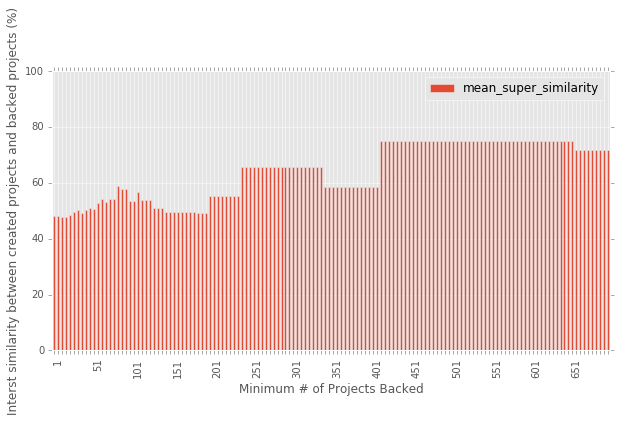

In [471]:
def percentage(x, pos):
    'The two args are the value and tick position'
    return '%d' % (x * 100)

def x_formatter(x, pos):
    if (x - 1) % 10 != 0:
        return ""
    return str((x - 1) * 5 + 1)

plt.figure()
ax = df_plot.plot.bar(x='min_backed', y='mean_super_similarity', figsize=(10, 5))
ax.set_ylabel('Interst similarity between created projects and backed projects (%)')
ax.set_xlabel('Minimum # of Projects Backed')
ax.set_ylim(bottom=0.0, top=1.0)
ax.yaxis.set_major_formatter(FuncFormatter(percentage))
ax.xaxis.set_major_formatter(FuncFormatter(x_formatter))

In [ ]:
def mean_specific_similarity(min_backed):
    if min_backed < 1:
        raise ValueError
    indices = (pd.notnull(df_tech_creators.specific_similarity)) & (df_tech_creators.backed > min_backed)
    return df_tech_creators.specific_similarity[indices].mean()

df_plot_specific = pd.DataFrame({'min_backed': range(1, 701, 5),
             'mean_super_similarity': [mean_specific_similarity(n) for n in range(1, 701, 5)]})

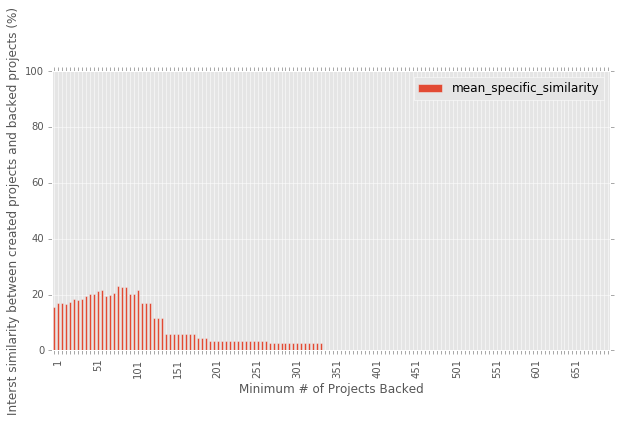

In [473]:
def percentage(x, pos):
    'The two args are the value and tick position'
    return '%d' % (x * 100)

def x_formatter(x, pos):
    if (x - 1) % 10 != 0:
        return ""
    return str((x - 1) * 5 + 1)

plt.figure()
ax = df_plot_specific.plot.bar(x='min_backed', y='mean_specific_similarity', figsize=(10, 5))
ax.set_ylabel('Interst similarity between created projects and backed projects (%)')
ax.set_xlabel('Minimum # of Projects Backed')
ax.set_ylim(bottom=0.0, top=1.0)
ax.yaxis.set_major_formatter(FuncFormatter(percentage))
ax.xaxis.set_major_formatter(FuncFormatter(x_formatter))

## H4.2: Similarity (Location-Based)
** People are more willing to back creators from the same country they are from. **

We thought that location might also be important in a backers' decision making process. According to the similarity theory, projects would get most help from the creator's country. For example, if there are 2 similar projects A and B. The creator of A is from Canada, while that of B is from Australia. Based on this hypothesis, there will be more Canadian backers for project A, and more Australian backers for project B.

We define in location-based similarity $S_L$ for each project, a measure with range [0, 1.0] that represents the fraction of projects backers from the same country as the project creator among all the backers.

The result showed that more than 60% of the backers were from the same country as the project creators among all projects in the Tech dataset, which we considered as a support of H4.2. However, marketing might be a confounding factor in this hypothesis, since it's very common that the target audience of a project and the creator are from the same place.

In [163]:
df = pd.read_csv('data/Kickstarter_Tech.csv', encoding='utf-8', index_col=0)

In [164]:
df.sort_values(by='top_countries').get(['location', 'top_countries']).head() # For visualization

,location,top_countries
1928,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...","[[""AR"", 10], [""US"", 10], [""SG"", 1], [""GB"", 1]]"
9188,"{""country"":""AT"",""urls"":{""web"":{""discover"":""htt...","[[""AT"", 18], [""US"", 4], [""DE"", 1], [""KR"", 1], ..."
5484,"{""country"":""AT"",""urls"":{""web"":{""discover"":""htt...","[[""AT"", 25], [""DE"", 1], [""US"", 1]]"
4989,"{""country"":""AU"",""urls"":{""web"":{""discover"":""htt...","[[""AU"", 102], [""US"", 15], [""GB"", 14], [""SG"", 6..."
6932,"{""country"":""AU"",""urls"":{""web"":{""discover"":""htt...","[[""AU"", 10], [""US"", 1]]"


In [171]:
creator_country_series = df.location.apply(lambda x: json.loads(x)['country'])
backer_countries_series = df.top_countries.apply(lambda x: Counter(dict(json.loads(x))))

** Compute localtion-based similarities **

$S_L = \frac{\#\ of \ Backers\ from\ The\ Same\ Country}{\#\ of\ Total\ Backers}$ 

In [185]:
similarities = []
for cc, bcs in zip(creator_country_series, backer_countries_series):
    total = sum(bcs.values())
    if cc in bcs:
        similarities.append(bcs[cc] / float(total))
    elif total > 0:
        similarities.append(0.0)
    else:
        similarities.append(np.nan)
similarities = np.array(similarities)

In [280]:
nan_count = np.sum(np.isnan(similarities))
print("%d projects didn't have any backers at all." % (nan_count))
zero_count = np.sum(similarities == 0.0)
print("%d projects didn't have any backers from the same country." % (zero_count))

9153 projects didn't have any backers at all.
58 projects didn't have any backers from the same country.


In [279]:
mean_similarity = np.mean(similarities[np.logical_not(np.isnan(similarities))])
print("%2.1f%% of backers are from the same country as the project creator." % (mean_similarity * 100))

64.7% of backers are from the same country as the project creator.


## H5: Effort
** Our Hypothesis: People who browse projects will be more likely to back creators who seem to put more effort into their Kickstarter Page. **

Let's define "effort" here as length of the Descriptions and Risks and Challenges section, as well as checking to see if Kickstarter project owners uploaded a video to their page.

Our results show that users with successful projects indeed do write more in both their Descriptions and Risks and Challenges section. We measured average length as the average character count, and found Descriptions average to be 5088 vs. 2806 (success vs. failed projects), and Risks and Challenges average to be 869 vs. 628 (succcess vs. failed projects). For videos, we found that the average number of videos per page is .9 on a successful page, vs. .6 on a failed page. Thus, we conclude that putting more effort on your page will lead it to be more successful. 

We cannot however make the assumption that just length and having a video matter, there was obviously something that went into the quality of the writing and video for it to be successful.

In [17]:
df = pd.read_csv('data/Kickstarter_Tech.csv', encoding='utf-8', index_col=0)

In [19]:
#make two dataframes, one for successful, one for failed projects
kstr_tech_success = df[df['state'] == 'successful']
kstr_tech_failed = df[df['state'] == 'failed']

In [20]:
def check_avg_len(data):
    sum = 0
    count_nan=0
    for dat in data:
        try:
            sum += len(dat)
        except:
            count_nan+=1
            sum += 0
    return sum/float(len(data) - count_nan), count_nan

In [21]:
#avg length of description for failed projects
failed_descriptions = kstr_tech_failed['descriptions']
avg_failed_desc, nan_count = check_avg_len(failed_descriptions)
print "avg_failed_desc", avg_failed_desc
print "nan_count", nan_count

print "\n"

#avg length of descriptions for successful projects
successful_descriptions = kstr_tech_success['descriptions']
avg_success_desc, nan_count = check_avg_len(successful_descriptions)
print "avg_success_desc", avg_success_desc
print "nan_count", nan_count

print "\n"

#avg length of risks for failed projects
failed_risks = kstr_tech_failed['risks_and_challenges']
avg_failed_risks, nan_count = check_avg_len(failed_risks)
print "avg_failed_risks", avg_failed_risks
print "nan_count", nan_count

print "\n"

#avg length of risks for successful projects
success_risks = kstr_tech_success['risks_and_challenges']
avg_success_risks, nan_count = check_avg_len(success_risks)
print "avg_success_risks", avg_success_risks
print "nan_count", nan_count

avg_failed_desc 2806.9330362
nan_count 0


avg_success_desc 5088.07827203
nan_count 0


avg_failed_risks 628.523866478
nan_count 2


avg_success_risks 869.142062473
nan_count 1


In [22]:
#now let's check for videos as video/kickstarter page
print "Average number of videos per page for successful projects",sum(kstr_tech_success['has_video'])/ float(len(kstr_tech_success))
print "Average number of videos per page for failed projects",sum(kstr_tech_failed['has_video'])/float(len(kstr_tech_failed))

Average number of videos per page for successful projects 0.906757912746
Average number of videos per page for failed projects 0.579084683118


## H6: Language
** Creators want potential backers to feel comfortable with their risks and challenges so successful projects use polite/ thankful language and positive sentiment. **

** Measuring Politeness/Gratitude **

We decided to measure politeness/gratitude by identifying some key words that expressed gratitude or politeness such as "thankful", "gratitude", etc. Instead of compiling a list ourselves, we found a politeness model [5], based on Danescu-Niculescu-Mizil et al.'s paper [6], downloaded a corpus of positive words that they use("liu-positive-words.txt"), and used it to search our Risks and Challenges section.

We measured a politeness/gratitude "score" for successful and failed projects. The results are:
Average score for Successful Projects:  0.0756236804884
Average score for Failed Projects:  0.0724241471227
Looking at the example printed in the cells below, we can see that these scores being low doesn't mean that the text isn't polite, scores are low because risks and challenges are long compared to the number of gratitude words they can even use. However, because Successful projects Risks and Challenges lengths are slightly longer, we could, but not confidently attribute the Successful Projects to being a little more polite.


** Measuring Positive Sentiment**

We used the VADER package [7] to measure sentiment of the Risks and Challenges. An example can be seen in the cells below. We were looking for overall positive sentiment, but our scores were in the neutral category, which makes sense. So, there were no new or cool findings with this.

In [24]:
text_file = open('data/liu-positive-words.txt', 'r')
positive_words = text_file.read().split('\n')
len(positive_words)

2007

In [25]:
#for successful projects:
success_rc = kstr_tech_success['risks_and_challenges']
#for failed projects:
failed_rc = kstr_tech_failed['risks_and_challenges']

In [26]:
def remove_stop_and_punct(sent, add_to_stop):
    stop = stopwords.words('english')
    punct = [r for r in string.punctuation]
    to_remove = stop + punct 
    if add_to_stop:
        to_remove += add_to_stop
    sent = [i for i in sent if i not in to_remove]
    return sent

def cleaned_sentences(sentences, add_to_stop):
    cleaned = []
    for sent in sentences:
        sent = sent.lower()
        cleaned.append(remove_stop_and_punct(nltk.word_tokenize(sent), add_to_stop))
    return cleaned

def get_sentences(risk):
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
    return sent_detector.tokenize(risk)


def get_tokenized_org(risks, stop_words_list= None):
    tokenized = []
    count_na  = 0
    for risk in risks:
        try:
            sent_tokenized = get_sentences(risk)
            temp = cleaned_sentences(sent_tokenized, stop_words_list)
            temp = [item for sublist in temp for item in sublist] 
            tokenized.append(temp)
        except:
            print risk
            count_na+=1
            tokenized.append(float('nan'))
    return tokenized, count_na

word tokenize

In [27]:
#one nan, meaning this was either a section without risks and challenges, or 
#a very weirdly formatted page
tokenized_risks_sc, count_na_risks_sc  = get_tokenized_org(success_rc,None)
print count_na_risks_sc

nan
1


In [28]:
tokenized_risks_f, count_na_risks_f = get_tokenized_org(failed_rc, None)
count_na_risks_f

nan
nan


2

In [29]:
#define polite/gratitude as the number of polite/positive words normalized by the length of the text
def score(risk):
    count_positive = 0
    for word in risk:
        if word in positive_words:
            count_positive+=1
    score = float(count_positive)/len(risk)
    return score, count_positive

def get_polite_score_arr(tokenized_risks):
    grattitude_scores = []
    for risk in tokenized_risks:
        try:
            sc, _pc = score(risk)
            grattitude_scores.append(sc)
        except:
            #for na, append na 
            grattitude_scores.append(float('nan'))
    return grattitude_scores

In [30]:
##print an example to see if it makes sense:
print success_risks.iloc[0]

As with any electro-mechanical product, there are risks associated with producing a sophisticated device such as The Hercules.  Supporters should feel very confident that we have spent the past 6 months product testing The Hercules by professional videographers and filmmakers.
We performed a prototype build as well as a preproduction build using a small quantity of units.  By doing so, we worked out the manufacturing bugs that doomed so many projects on Kickstarter.
The risks associated with this product is greatly reduced by the steps we have taken prior to full scale manufacturing.


In [31]:
#problem with this "score" because there aren't a lot of gratitude words compared
#to the length of th
score(tokenized_risks_sc[0])

(0.08163265306122448, 4)

In [32]:
grattitude_score_sc = get_polite_score_arr(tokenized_risks_sc)
grattitude_score_f = get_polite_score_arr(tokenized_risks_f)

In [33]:
#get averages of scores
print "Average score for Successful Projects: ",np.nanmean(np.asarray(grattitude_score_sc))
print "Average score for Failed Projects: ", np.nanmean(np.asarray(grattitude_score_f))

Average score for Successful Projects:  0.0756236804884
Average score for Failed Projects:  0.0724241471227


In [34]:
#let's plot the count of gratitude words used over all successful and all failed projects
#to compare these graphs
def get_pos_word_array(risks):
    arr = []
    na_count  = 0
    max_pc = 0
    idx = 0
    for risk in risks:
        try:
            sc, pc = score(risk)
            arr.append(pc)
            if pc > max_pc:
                best_risk = risk
                best_idx = idx
        #for na, don't append
        except:
            print risk
            na_count += 1
        idx+=1
    return arr, na_count, best_risk, best_idx

# pos_count_s = get_pos_word_array(tokenized_risks_sc)
# pos_count_f = get_pos_word_array(tokenized_risks_f)

In [35]:
#also get the risk with the most positive words
pos_count_s, na_count_s, best_risk_s, best_idx_s = get_pos_word_array(tokenized_risks_sc)

nan


In [37]:
#10 are blank for whatever reason, this could be that they didn't write anything
#or that we couldn't successfully scrape 10 projects. 2 are na
pos_count_f, na_count_f, best_risk_f, best_idx_f = get_pos_word_array(tokenized_risks_f) 

[]
[]
[]
[]
nan
nan
[]
[]
[]
[]
[]
[]


In [39]:
print "Range of politeness/gratitude words for successful projects is ", min(pos_count_s), " to ", max(pos_count_s)
print "\n"
print "Range of politeness/gratitude words for failed projects is ", min(pos_count_f), " to ", max(pos_count_f)

Range of politeness/gratitude words for successful projects is  0  to  46


Range of politeness/gratitude words for failed projects is  0  to  111


** The most polite/gratitude word filled successful and failed risks and challenges blurbs are below **

In [36]:
# "most polite"
print success_rc.iloc[best_idx_s]

The primary challenge we face is writing the artificial intelligence algorithms. Creating robotics algorithms that work well in the real world is difficult because of complex and changing environments. Developing algorithms on a memory and speed limited microcontroller is even harder. The project has the risk of not achieving the dynamic intelligence we believe we can program into Mousr, resulting in slower reaction times or poor sensitivity at far distances. However, these are the kinds of challenges the team has studied and overcome in graduate school at the University of Illinois at Urbana-Champaign, as overviewed earlier. Additionally, we plan to make the firmware updatable through Bluetooth, allowing us to fix bugs and update algorithms even after shipment of the final hardware.There are several risks associated with manufacturing hardware that could delay the project. Some of the tasks we have to complete include creating tooling, making a test jig to ensure every Mousr off the l

In [38]:
#"most polite" (this is the 111 polite words)
print failed_rc.iloc[best_idx_f]

Since our first prototypes, we have come a long way and have been able to overcome many challenges. We have been able to do what really few people have been able to do: get a robot to run while selling it at an affordable price. We believe this is a real demonstration of how motivated we are and that we never give up, whatever the challenges are. Talking about challenges, do we think we are still facing some? Of course, we are, like in any innovative project. One of the main risks with a KickStarter project like this one is that it is really hard to estimate correctly how many backers one will have, which can change drastically the manufacturing methods. Fortunately enough, from our experience, we know and have been working with several manufacturers that will be able to handle a large range of production, from low-scale quantity to large-scale orders. The second risk we see is quality control. In order to get the best injected molded part, we will spend a huge amount of time perfectin

**Printing some more statistics shows that successful projects do use some more polite/grateful words **

In [40]:
import statistics
print "FOR FAILED PROJECTS:"
print "Median of polite/gratitude word count: ",statistics.median(pos_count_f)
print "Mean of polite/gratitude words count: ", statistics.mean(pos_count_f)
print "\n"
print "FOR SUCCESSFUL PROJECTS:"
print "Median of polite/gratitude word count: ", statistics.median(pos_count_s)
print "Mean of polite/gratitude words count: ", statistics.mean(pos_count_s)


FOR FAILED PROJECTS:
Median of polite/gratitude word count:  3
Mean of polite/gratitude words count:  4.01295308588


FOR SUCCESSFUL PROJECTS:
Median of polite/gratitude word count:  5
Mean of polite/gratitude words count:  5.69533590073


**measure sentiment**

In [41]:
##use vader:
import vaderSentiment
from vaderSentiment import vaderSentiment

def get_sentences2(risks):
    nan_count = 0
    tokenized_sent = []
    for risk in risks:
        try:
            sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
            tokenized_sent.append(sent_detector.tokenize(risk))
        except:
            #these are for all the nans
            nan_count+=1
    return tokenized_sent, nan_count

def get_vader_sentiment(rc):
    sentiments=[]
    count_na = 0
    for risk in rc:
        try:
            for sent in risk:
                sentiments.append(vaderSentiment.sentiment(sent))
        except:
            count_na+=1  
    return sentiments, count_na

In [42]:
tokenized_tech_failed_rc, nan_count_failed_rc = get_sentences2(failed_rc)
tokenized_tech_success_rc, nan_count_success_rc = get_sentences2(success_rc)

In [43]:
#for successful projects:
success_sentiment, count_na_s = get_vader_sentiment(tokenized_tech_success_rc)
#for failed projects:
failed_sentiment, count_na_f = get_vader_sentiment(tokenized_tech_failed_rc)

** Let's check to see if sentiment scores make sense. The 4 cells below show the sentiment and example for a successful project and a failed project **

In [49]:
success_sentiment[0]

{'compound': 0.3612, 'neg': 0.101, 'neu': 0.725, 'pos': 0.174}

In [50]:
tokenized_tech_success_rc[0]

[u'As with any electro-mechanical product, there are risks associated with producing a sophisticated device such as The Hercules.',
 u'Supporters should feel very confident that we have spent the past 6 months product testing The Hercules by professional videographers and filmmakers.',
 u'We performed a prototype build as well as a preproduction build using a small quantity of units.',
 u'By doing so, we worked out the manufacturing bugs that doomed so many projects on Kickstarter.',
 u'The risks associated with this product is greatly reduced by the steps we have taken prior to full scale manufacturing.']

In [45]:
print failed_sentiment[0]
tokenized_tech_failed_rc[0]

[u"I've been a software developer for 40 years.",
 u'To me, "can\'t" is a four letter word I almost never use.',
 u'And I have always finished what I started.',
 u'See more about me in the [About] section of dstechlabs.comThe first task is to assemble a small team of quality software developers and inspire greatness from them.',
 u'I\'ve been a successful team-lead for decades and can guide them to Keep Code Simple, Consistent and Maintainable.The next task is finding a suitable online advertising manager who will talk to manufacturers and convince them that donating products is far less expensive than other ad campaigns.From there, we plug on toward our "Go Live" event in the fourth quarter of 2016.']

In [46]:
#now get overall sentiment average and return
def return_avg_sentiment(sentiments):
    compound_avg =  sum(sent['compound'] for sent in sentiments) / float(len(sentiments))
    negative_avg =  sum(sent['neg'] for sent in sentiments) / float(len(sentiments))
    neutral_avg =  sum(sent['neu'] for sent in sentiments) / float(len(sentiments))
    positive_avg =  sum(sent['pos'] for sent in sentiments) / float(len(sentiments))
    return {'compound': compound_avg, 'neg': negative_avg, 'neu': neutral_avg, 'pos': positive_avg}

** The two cells below show the average sentiment of the successful and failed Risks and Challenges sections **

In [52]:
avg_success = return_avg_sentiment(success_sentiment)
avg_success

{'compound': 0.2072480885820128,
 'neg': 0.04264802963960934,
 'neu': 0.8414690131357377,
 'pos': 0.11504117547995922}

In [53]:
avg_failed = return_avg_sentiment(failed_sentiment)
avg_failed

{'compound': 0.20430246387599543,
 'neg': 0.04419672509817003,
 'neu': 0.8339837538177238,
 'pos': 0.11997223006442014}

## Conclusions

In conclusion, we tested many of the above hypotheses, some of which were proven right or wrong.

Having been inspired originally by [1], we found that requesting for pizza on Reddit and setting up a Kickstarter page are very different. For example, [1] found that for requests, people are polite and use positive sentiment, but we couldn't reach a significant similar conclusion for Kickstarter. We tried working with topic models on the Risks and Challenges section within one subtopic within Technology to see if we could find different distributions of risk topics for failed and successful projects, but weren't successful so didn't include it in this notebook. Additionally, the language on Kickstarter is very different than requesting for pizza. On Kickstarter, it is less about requesting and telling why you need the money, but more about showcasing your product and telling others how cool it is.



### Future Work.
We started looking at user profiles on Kicktarter and reached conclusions about user similarities such as, users indeed do want to back projects that are similar (category + country) to their own. We saw there is a lot more information on users' profile page such as whether users are connected to Facebook, when they last logged in, and their name. We want to look at whether providing this information increases trust and helps projects get backed. Editor's also choose "Projects we love", and these projects in turn get a badge, so we could scrape this information and see if it helps projects. We noticed that a lot of these projects get overfunded, so we want to see at what point the projects get overfunded, and see how much people still continue to contribute to the project. Scraping this information is a little different than the data we have in that we'd have to scrape the same page overtime.


## References
1. Althoff, T., & Danescu-Niculescu-Mizil, C. (2014). How to ask for a favor: A case study on the success of altruistic requests. arXiv.org.
2. Mitra, T., & Gilbert, E. (2014). The language that gets people to give: phrases that predict success on kickstarter (pp. 49–61). Presented at the CSCW '14: Proceedings of the 17th ACM conference on Computer supported cooperative work & social computing, ACM. http://doi.org/10.1145/2531602.2531656
3. Ammons Scientific - Psychological Reports - 55(1):139 - PDF. (1984). Ammons Scientific - Psychological Reports - 55(1):139 - PDF. http://doi.org/10.2466/pr0.1984.55.1.139
4. Persuasive technology: using computers to change what we think and do. (2002). Persuasive technology: using computers to change what we think and do.
5. https://github.com/sudhof/politeness
6. Cristian Danescu-Niculescu-Mizil, Moritz Sudhof, Dan Jurafsky, Jure Leskovec, Christopher Potts. A computational approach to politeness with application to social factors. Proceedings of ACL, 2013.
7. https://pypi.python.org/pypi/vaderSentiment